# ISLR- Python: Applied 8

- [A-B. Generate Simulated Data](#A.-Generate-Simulated-Data)
- [C. Perform Best Subset Selection](#B.-Perform-Best-Subset-Selection)
- [D. Repeat Using Forward Step Selection](#D.-Repeat-Using-Forward-Step-Selection)
- [E. Fit a Lasso Model](#E.-Fit-a-Lasso-Model)
- [F. Generate another Response and Fit](#F.-Generate another Response and Fit)

In [95]:
# Get some standard packages
import numpy as np
import pandas as pd
import statsmodels.api as sm

from tqdm import tqdm 
from operator import itemgetter
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV

from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('ggplot') # emulate R's pretty plotting

# print numpy arrays with precision 4
np.set_printoptions(precision=4)

## A-B. Generate Simulated Data

In [126]:
# Generate random normal predictors
np.random.seed(0)
X = np.random.randn(100,1)
# Generate noises term
eps = np.random.randn(100,1)

# Create a response vector Y with coeffecients of your choice
beta = [3, 10, -1.2, 7]
Y = beta[0] + beta[1]*X + beta[2]*X**2 + beta[3]*X**3 + eps

# generate polynomial features
poly = PolynomialFeatures(degree=10, include_bias=False)
X_arr = poly.fit_transform(X)

# Create a dataframe for response and predictors
col_names = ['Y']+['X'+ str(i) for i in range(1, 11)]
df = pd.DataFrame(np.concatenate((Y,X_arr), axis=1), columns=col_names)
df.head()

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,57.216060,1.764052,3.111881,5.489520,9.683801,17.082733,30.134834,53.159425,93.776009,165.425788,291.819750
1,5.910191,0.400157,0.160126,0.064075,0.025640,0.010260,0.004106,0.001643,0.000657,0.000263,0.000105
2,16.930305,0.978738,0.957928,0.937561,0.917626,0.898116,0.879020,0.860330,0.842038,0.824134,0.806612
3,99.122527,2.240893,5.021602,11.252875,25.216490,56.507461,126.627185,283.757997,635.871366,1424.919820,3193.093133
4,61.912455,1.867558,3.487773,6.513618,12.164559,22.718020,42.427220,79.235294,147.976506,276.354706,516.108440


## Perform Best Subset Selection

In the lab we wrote a function called best_subsets which returns the best model for each number of attributes. Jupyter notebooks are not python files so they are not directly importable. To import another jupyter notebook we need to write a class that has import methods like this:

http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Importing%20Notebooks.html

I might do that later but for now I am copying the function from that lab directly here.

In [117]:
# Best subset selection function...
def best_subsets(dataframe, predictors, response, max_features=8):
    """
    Regresses response onto subsets of the predictors in dataframe. Compares models with equal feature 
    numbers choosing the one with the lowest RSS as the 'best' model for that number of features.
    
    PARAMETERS
    ----------
    dataframe : pandas dataframe obj containing responses and predictors
    predictors : list of column names of dataframe used as features
    response : list of column name of dataframe used as target
    
    RETURNS
    -------
    a list of best models, one per feature number
    
    ex.
    [best 1 feat model, best two feat model] = best_subsets(df, predictors, response, max_features = 2)
    """
    
    def process_linear_model(features):
        """
        Constructs Linear Model Regression of response onto features.
        """
        # Create design Matrix
        X = sm.add_constant(dataframe[features])
        y = dataframe[response]

        model = sm.OLS(y,X).fit()
        RSS = model.ssr
        return (model, RSS)

    def get_best_kth_model(k):
        """
        Returns the model from all models with k-predictors with the lowest RSS.
        """
        results = []

        for combo in combinations(predictors, k):
            # process linear model with this combo of features
            results.append(process_linear_model(list(combo)))

        # sort the models and return the one with the smallest RSS
        return sorted(results, key= itemgetter(1)).pop(0)[0]
    
    models =[]
    for k in tqdm(range(1,max_features+1)):
        models.append(get_best_kth_model(k))
    
    return models

In [118]:
# Call best subset returning the best models for each number of features we have 10 features
models = best_subsets(df, predictors=list(df.columns[1:]), response=['Y'], max_features=10)

100%|██████████| 10/10 [00:01<00:00,  5.04it/s]


** Compare the models using Cp, BIC and R**2 **

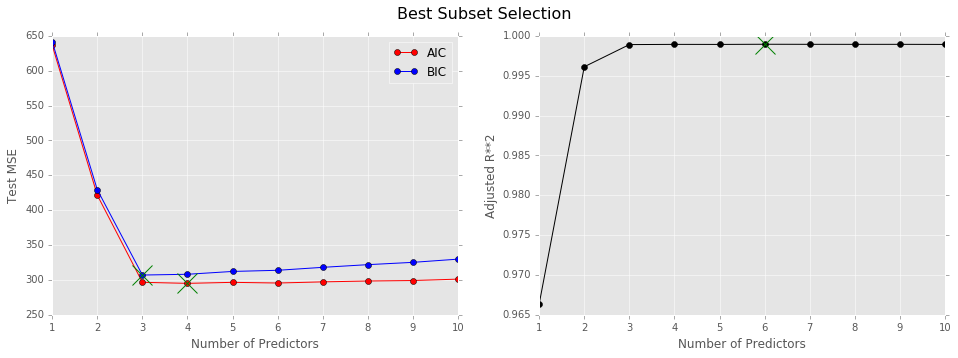

In [119]:
# Now that we have the best models for a given number of features we can compare models with different
# predictors using aic, bic and r_adj. Note AIC and Mallow's Cp are proportional to each other. We will 
# create plots of these statistics to find the best model.
aics = [models[x].aic for x in range(len(models))]
bics = [models[x].bic for x in range(len(models))]
r_adj = [models[x].rsquared_adj for x in range(len(models))]

# find the mins/maxes
min_aic_index, min_aic = min(enumerate(aics), key=itemgetter(1))
min_bic_index, min_bic = min(enumerate(bics), key=itemgetter(1))
max_radj_index, max_radj = max(enumerate(r_adj), key=itemgetter(1))

num_predictors = np.linspace(1,len(models),len(models))
# Create a plot
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(16,5))
# Add test MSE estimates
ax1.plot(num_predictors, aics, 'r', marker='o', label='AIC');
ax1.plot(num_predictors, bics, 'b', marker='o', label='BIC')

# add the minimums to the axis
ax1.plot(min_aic_index+1, min_aic, 'gx', markersize=20, markeredgewidth=1)
ax1.plot(min_bic_index+1, min_bic, 'gx', markersize=20, markeredgewidth=1)

# Labels and Legend
ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('Test MSE');
ax1.legend(loc='best');

# Add Adj R**2
ax2.plot(num_predictors, r_adj,'k', marker='o')
ax2.plot(max_radj_index+1, max_radj, 'gx', markersize=20, markeredgewidth=1)
ax2.set_xlabel('Number of Predictors');
ax2.set_ylabel('Adjusted R**2');

fig.suptitle('Best Subset Selection', fontsize=16);

So The AIC, BIC and R^2 each yield models with different numbers of predictors BIC->2, AIC -> 4 and R^2 -> 6.

In [127]:
models[3].params

const    3.177226
X1       9.730710
X2      -1.315664
X3       7.377513
X5      -0.061077
dtype: float64

## Repeat Using Forward Step Selection

In [121]:
def forward_step_select(df, predictors, response, max_features=10):
    """
    Regresses response onto predictors using a forward step algorithm. Features are added based on minimum RSS.
    
    PARAMETERS
    -----------
    df : dataframe containing predictors and responses
    predictors : list of all possible model predictors
    response : list[variable] to regress onto predictors in df
    max_features : maximum number of features to use
    
    RETURNS
    --------
    list of models with increasing number of features upto max_features
    
    """
    
    def process_linear_model(features):
        """
        Constructs Linear Model Regression of response onto features.
        """
        # Create design Matrix
        X = sm.add_constant(df[features])
        y = df[response]

        model = sm.OLS(y,X).fit()
        RSS = model.ssr
        return (model, RSS)

    def update_model(best_features, remaining_features):
        """
        Computes the RSS of possible new models and returns the model with the lowest RSS.
        """
        results = []
        
        for feature in remaining_features:
            results.append(process_linear_model(best_features + [feature]))
            
        # select model with the lowest RSS
        new_model = sorted(results, key= itemgetter(1)).pop(0)[0]
        new_features = list(new_model.params.index)[1:]
        
        return new_features, new_model
    
    # Create list to hold models, model features and the remaining features to test
    models = []
    best_features = []
    remaining_features = predictors
    
    while remaining_features and len(best_features) < max_features:
        
        # get the best new feature set from update_model
        new_features, new_model = update_model(best_features, remaining_features)
        # update the best features to include the one we just found
        best_features = new_features  
        # reduce the available features for the next round
        remaining_features =  [feature for feature in predictors if feature not in best_features]
        
        # append the new_features and model so we can compare models with different features later
        models.append((new_features,new_model))
        
    return models

In [122]:
# Call our forward step function
features = list(df.columns[1:])
# call forward_step_select
f_models = forward_step_select(df,predictors=features, response=['Y'], max_features=10)

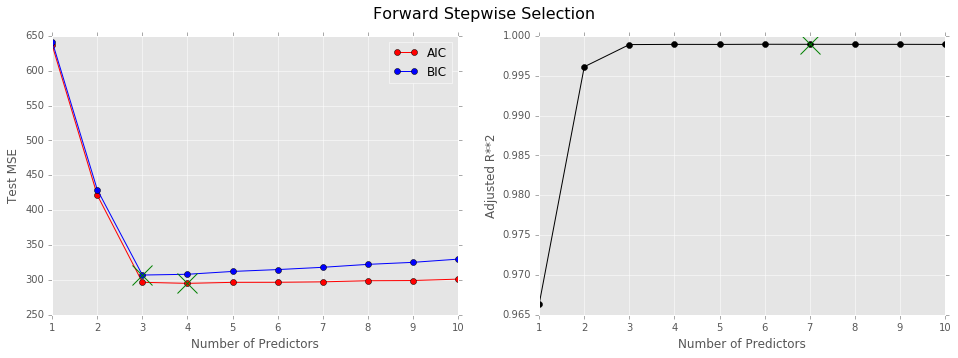

In [123]:
# Now that we have the best models for a given number of features we can compare models with different
# predictors using aic, bic and r_adj. Note AIC and Mallow's Cp are proportional to each other. We will 
# create plots of these statistics to find the best model.
f_aics = [f_models[x][1].aic for x in range(len(f_models))]
f_bics = [f_models[x][1].bic for x in range(len(f_models))]
f_r_adj = [f_models[x][1].rsquared_adj for x in range(len(f_models))]

# find the mins/maxes
min_aic_index, min_aic = min(enumerate(f_aics), key=itemgetter(1))
min_bic_index, min_bic = min(enumerate(f_bics), key=itemgetter(1))
max_radj_index, max_radj = max(enumerate(f_r_adj), key=itemgetter(1))

num_predictors = np.linspace(1,len(f_models),len(f_models))
# Create a plot
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(16,5))
# Add test MSE estimates
ax1.plot(num_predictors, f_aics, 'r', marker='o', label='AIC');
ax1.plot(num_predictors, f_bics, 'b', marker='o', label='BIC')

# add the minimums to the axis
ax1.plot(min_aic_index+1, min_aic, 'gx', markersize=20, markeredgewidth=1)
ax1.plot(min_bic_index+1, min_bic, 'gx', markersize=20, markeredgewidth=1)

# Labels and Legend
ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('Test MSE');
ax1.legend(loc='best');

# Add Adj R**2
ax2.plot(num_predictors, r_adj,'k', marker='o')
ax2.plot(max_radj_index+1, max_radj, 'gx', markersize=20, markeredgewidth=1)
ax2.set_xlabel('Number of Predictors');
ax2.set_ylabel('Adjusted R**2');

fig.suptitle('Forward Stepwise Selection', fontsize=16);

In [128]:
f_models[3][1].params

const    3.177226
X3       7.377513
X1       9.730710
X2      -1.315664
X5      -0.061077
dtype: float64

In [129]:
f_models[2][1].params

const     3.143159
X3        6.985227
X1       10.162551
X2       -1.266798
dtype: float64

** The best-subset and forward step algorthims may select different models depending on the information criteria. Best-subset (AIC) located a 4-feature model consisting of X1,X2 X3 and X5. Forward selected a 4-feature model that also includes with the same features if using AIC. If we look at the model with the BIC criteria, then we get a three feature model. This is consistent with the BIC placing a heavier penalty on models with more features. ** 

## E. Fit a Lasso Model

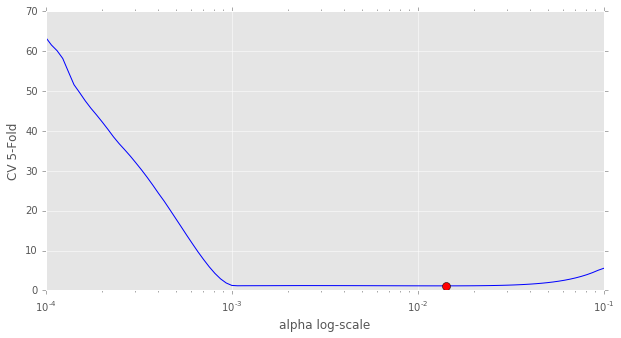

In [185]:
# Use LassoCV to perform 5-fold cross validation to determine optimal alpha
lasso_cv = LassoCV(alphas = np.logspace(-4,-1,100), normalize=True, cv=5, max_iter=100000)
lasso_cv.fit(df[features].values, df.Y.values)

# The mse estimates are the mean aross folds (cols)
mses = np.mean(lasso_cv.mse_path_, axis=1)

# Plot CV error vs alpha
fig, ax = plt.subplots(figsize=(10,5));
ax.plot(lasso_cv.alphas_,mses, color='b');
ax.plot(lasso_cv.alpha_, np.min(mses), marker='o', color='r', markersize=8);
ax.set_xlabel('alpha log-scale');
ax.set_xscale('log')
ax.set_ylabel('CV 5-Fold');

In [162]:
lasso_cv.alpha_

0.014174741629268049

** So the lasso model finds an alpha of 0.014. The coeffecients at this alpha are very close to our simulated data**

In [177]:
print(pd.Series(data = np.hstack([lasso_cv.intercept_,lasso_cv.coef_]), index=['Intercept'] + features))

Intercept     3.030071
X1           10.076142
X2           -1.146128
X3            6.959901
X4           -0.000000
X5            0.000000
X6           -0.000000
X7            0.000000
X8           -0.000000
X9            0.000000
X10          -0.000000
dtype: float64


## Generate another Response and Fit

In [244]:
# Generate a new response
beta = [3, 19]
Y_new = beta[0] + beta[1]*X**7+eps

# Make a new datafram
df2 = pd.DataFrame(np.concatenate((Y_new,X_arr), axis=1), columns=col_names)
df2.head()

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,1014.912230,1.764052,3.111881,5.489520,9.683801,17.082733,30.134834,53.159425,93.776009,165.425788,291.819750
1,1.683456,0.400157,0.160126,0.064075,0.025640,0.010260,0.004106,0.001643,0.000657,0.000263,0.000105
2,18.075786,0.978738,0.957928,0.937561,0.917626,0.898116,0.879020,0.860330,0.842038,0.824134,0.806612
3,5395.371343,2.240893,5.021602,11.252875,25.216490,56.507461,126.627185,283.757997,635.871366,1424.919820,3193.093133
4,1507.297460,1.867558,3.487773,6.513618,12.164559,22.718020,42.427220,79.235294,147.976506,276.354706,516.108440


### Perform Best Subset

In [245]:
#Perform Best Subset Again
models = best_subsets(df2, predictors=list(df2.columns[1:]), response=['Y'], max_features=10)

100%|██████████| 10/10 [00:01<00:00,  5.16it/s]


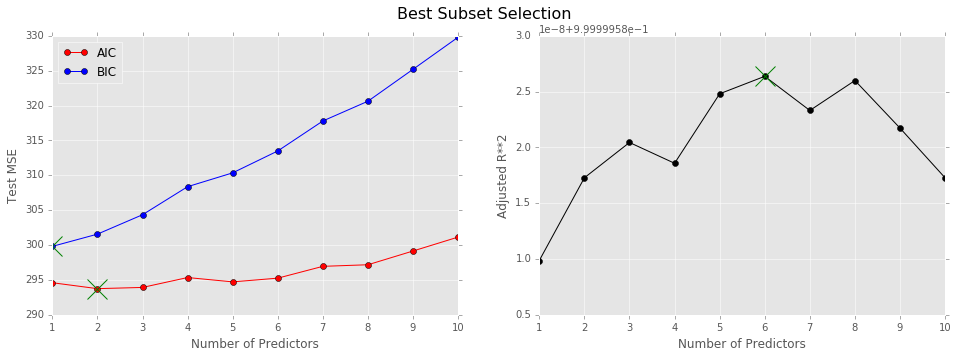

In [246]:
# Now that we have the best models for a given number of features we can compare models with different
# predictors using aic, bic and r_adj. Note AIC and Mallow's Cp are proportional to each other. We will 
# create plots of these statistics to find the best model.
aics = [models[x].aic for x in range(len(models))]
bics = [models[x].bic for x in range(len(models))]
r_adj = [models[x].rsquared_adj for x in range(len(models))]

# find the mins/maxes
min_aic_index, min_aic = min(enumerate(aics), key=itemgetter(1))
min_bic_index, min_bic = min(enumerate(bics), key=itemgetter(1))
max_radj_index, max_radj = max(enumerate(r_adj), key=itemgetter(1))

num_predictors = np.linspace(1,len(models),len(models))
# Create a plot
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(16,5))
# Add test MSE estimates
ax1.plot(num_predictors, aics, 'r', marker='o', label='AIC');
ax1.plot(num_predictors, bics, 'b', marker='o', label='BIC')

# add the minimums to the axis
ax1.plot(min_aic_index+1, min_aic, 'gx', markersize=20, markeredgewidth=1)
ax1.plot(min_bic_index+1, min_bic, 'gx', markersize=20, markeredgewidth=1)

# Labels and Legend
ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('Test MSE');
ax1.legend(loc='best');

# Add Adj R**2
ax2.plot(num_predictors, r_adj,'k', marker='o')
ax2.plot(max_radj_index+1, max_radj, 'gx', markersize=20, markeredgewidth=1)
ax2.set_xlabel('Number of Predictors');
ax2.set_ylabel('Adjusted R**2');

fig.suptitle('Best Subset Selection', fontsize=16);

In [247]:
# Again the AIC and BIC predict small feature models, Though R^2 is useless now. The best two feature model is
models[1].params

const     3.063943
X3        0.104043
X7       18.996606
dtype: float64

** Notice that the only large coeffecient is the seventh term as expected and the coeffecients are very close to the simulated data set.**

### Perform Lasso

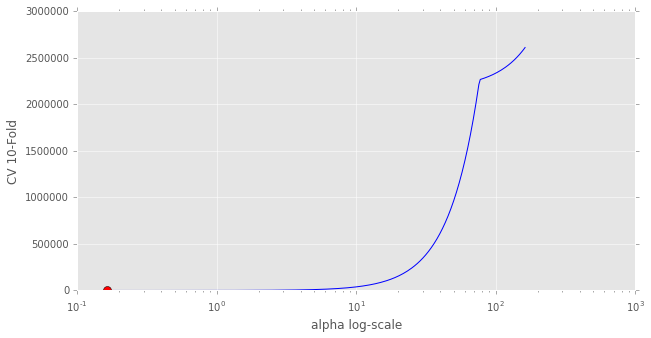

In [248]:
np.random.seed(1)
# Use LassoCV to perform 5-fold cross validation to determine optimal alpha
lasso_cv = LassoCV(n_alphas=300, normalize=True, cv=10, max_iter=100000)
lasso_cv.fit(df2[features].values, df2.Y.values)

# The mse estimates are the mean aross folds (cols)
mses = np.mean(lasso_cv.mse_path_, axis=1)

# Plot CV error vs alpha
fig, ax = plt.subplots(figsize=(10,5));
ax.plot(lasso_cv.alphas_,mses, color='b');
ax.plot(lasso_cv.alpha_, np.min(mses), marker='o', color='r', markersize=8);
ax.set_xlabel('alpha log-scale');
ax.set_xscale('log')
ax.set_ylabel('CV 10-Fold');

In [249]:
lasso_cv.alpha_

0.16237934300968787

In [250]:
print(pd.Series(data = np.hstack([lasso_cv.intercept_,lasso_cv.coef_]), index=['Intercept'] + features))

Intercept     3.424914
X1           -0.000000
X2            0.000000
X3            0.000000
X4            0.000000
X5            3.258490
X6            0.000000
X7           17.582551
X8            0.000000
X9            0.139571
X10           0.000000
dtype: float64


** The lasso coeffecients at this alpha now include two noise terms (i.e. not related to the signal) the 5th and 9th powers of X. In this case Lasso has been outperformed by the best subset selection. One explanantion is that in a single variable model with 9 noise terms, the Lasso fit worsens because there are more noise terms relative to signal terms. As we increase the number of noise terms we excerbate the risk of overfitting since by chance some of the features may be given non-zero coeffecients without any improvement in test error. **